# Bridge Matching

## Import

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import math
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, "../src")
from BM import MLP, SDE_Solver, train_velocity_forward, sample_2d_gaussian, sample_2d_swiss_roll
%matplotlib inline

## Global Params

In [2]:
#======
#Device params
DEVICE = "cuda"
#SEED = 2024
#torch.manual_seed(SEED); np.random.seed(SEED)

#=====
#Data params
STD = 0.5 #Swiss Roll std (manages the "tightness")
DATA_N = 5000 #number of points 

#=====
#Neural network params
LAYER_LIST = [3, 256, 512, 1024, 512, 256, 2]
L_R = 1e-4
EPOCHES = 20000
BATCH_SIZE = 64

#======
#SDE params
EPS = 1e-1#Epsilon or variance for SDE
STEPS = 1000 #Steps for time discretization in Euler-Maruyama method

## Velocity/Drift model Inference

1. $V_{\theta}(x,t)$ - velocity or drift pointing from Normal to Swiss Roll 
2. $V_{\phi}(x,t)$ - velocity or drift pointing from Swiss Roll to Normal 
3. $t{\epsilon}[0,1]$ \
$Therefore,$ $V_{mean}(x,t) = [V_{\theta}(x,t) - V_{\phi}(x,t)] / 2$



In [3]:
#Load networks
velocity_forward = torch.load(f"../checkpoints/forward_eps_1e-1.model")
velocity_backward = torch.load(f"../checkpoints/backward_eps_1e-1.model")

/tmp/ipykernel_17516/1064196981.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  velocity_forward = torch.load(f"../checkpoints/forward_eps_1e-1.model")
/tmp/ipykernel_17

## SDE Solver

In [9]:
solver= SDE_Solver(vnet=velocity_forward, steps=STEPS, eps=EPS, device=DEVICE)
solver_b = SDE_Solver(vnet=velocity_backward, steps=STEPS, eps=EPS, device=DEVICE)

## Plot Results

#### $V_{\theta}(x,t)$: velocity/drift from Gaussian to Swiss Roll

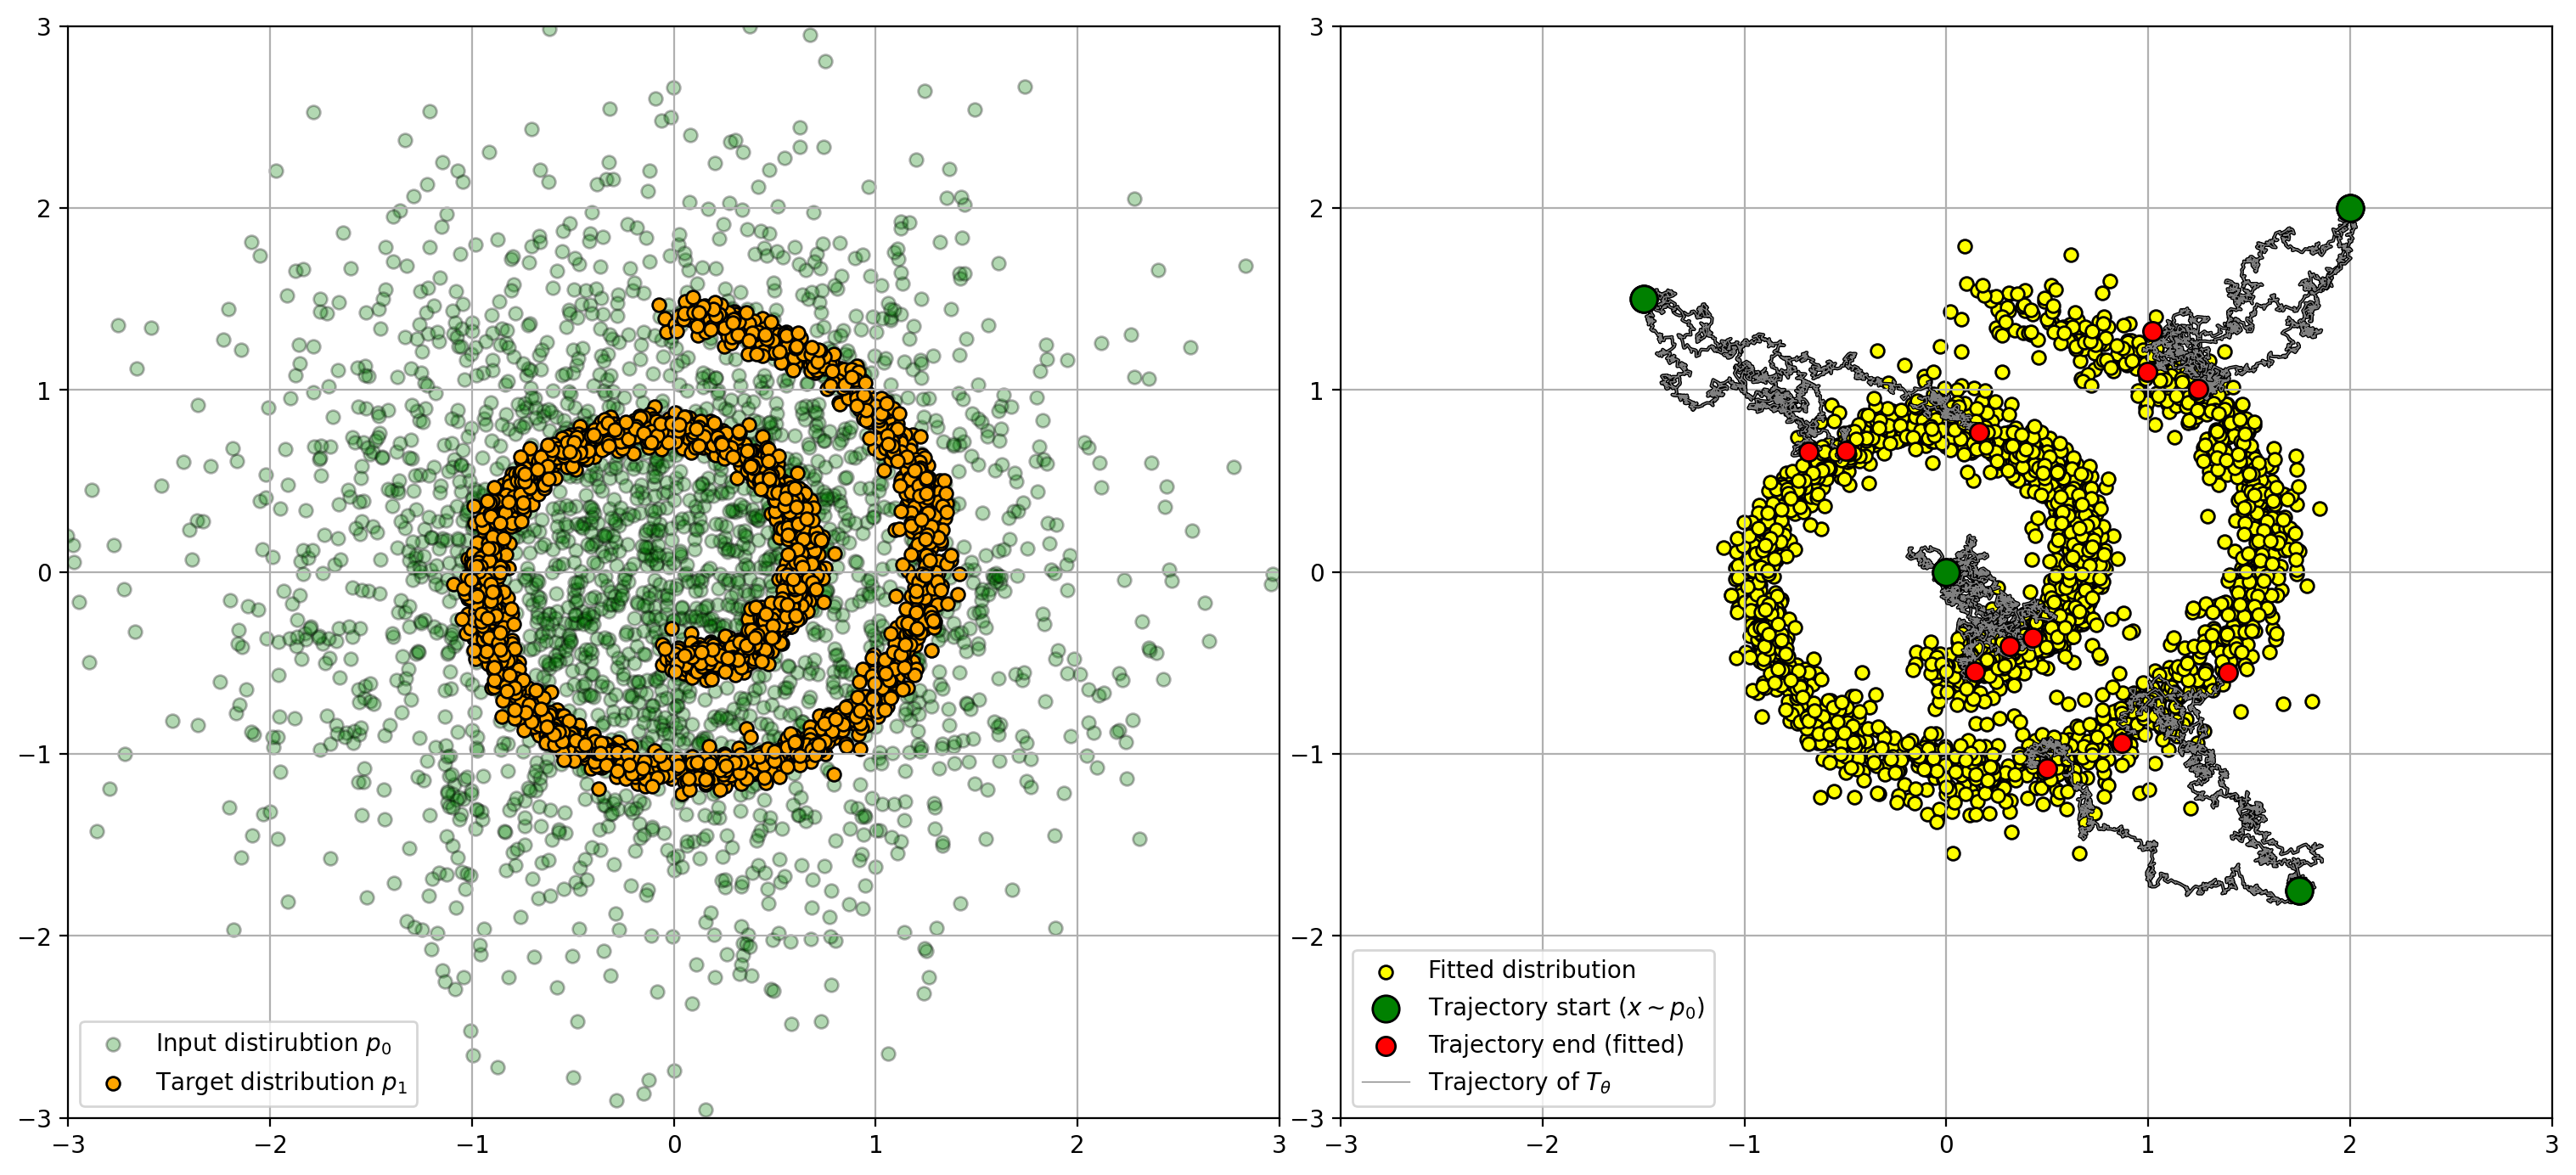

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

x_samples = sample_2d_gaussian(int(DATA_N*0.5))
y_samples = sample_2d_swiss_roll(int(DATA_N*0.5), std=STD)
trajectory, y_pred = solver.solve(x_samples)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])

tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)

trajectory_example, pred_example = solver.solve(tr_samples)

#print(pred_example)

ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.1)


#### $V_{\phi}(x,t)$ -- velocity/drift from Swiss Roll to Gaussian

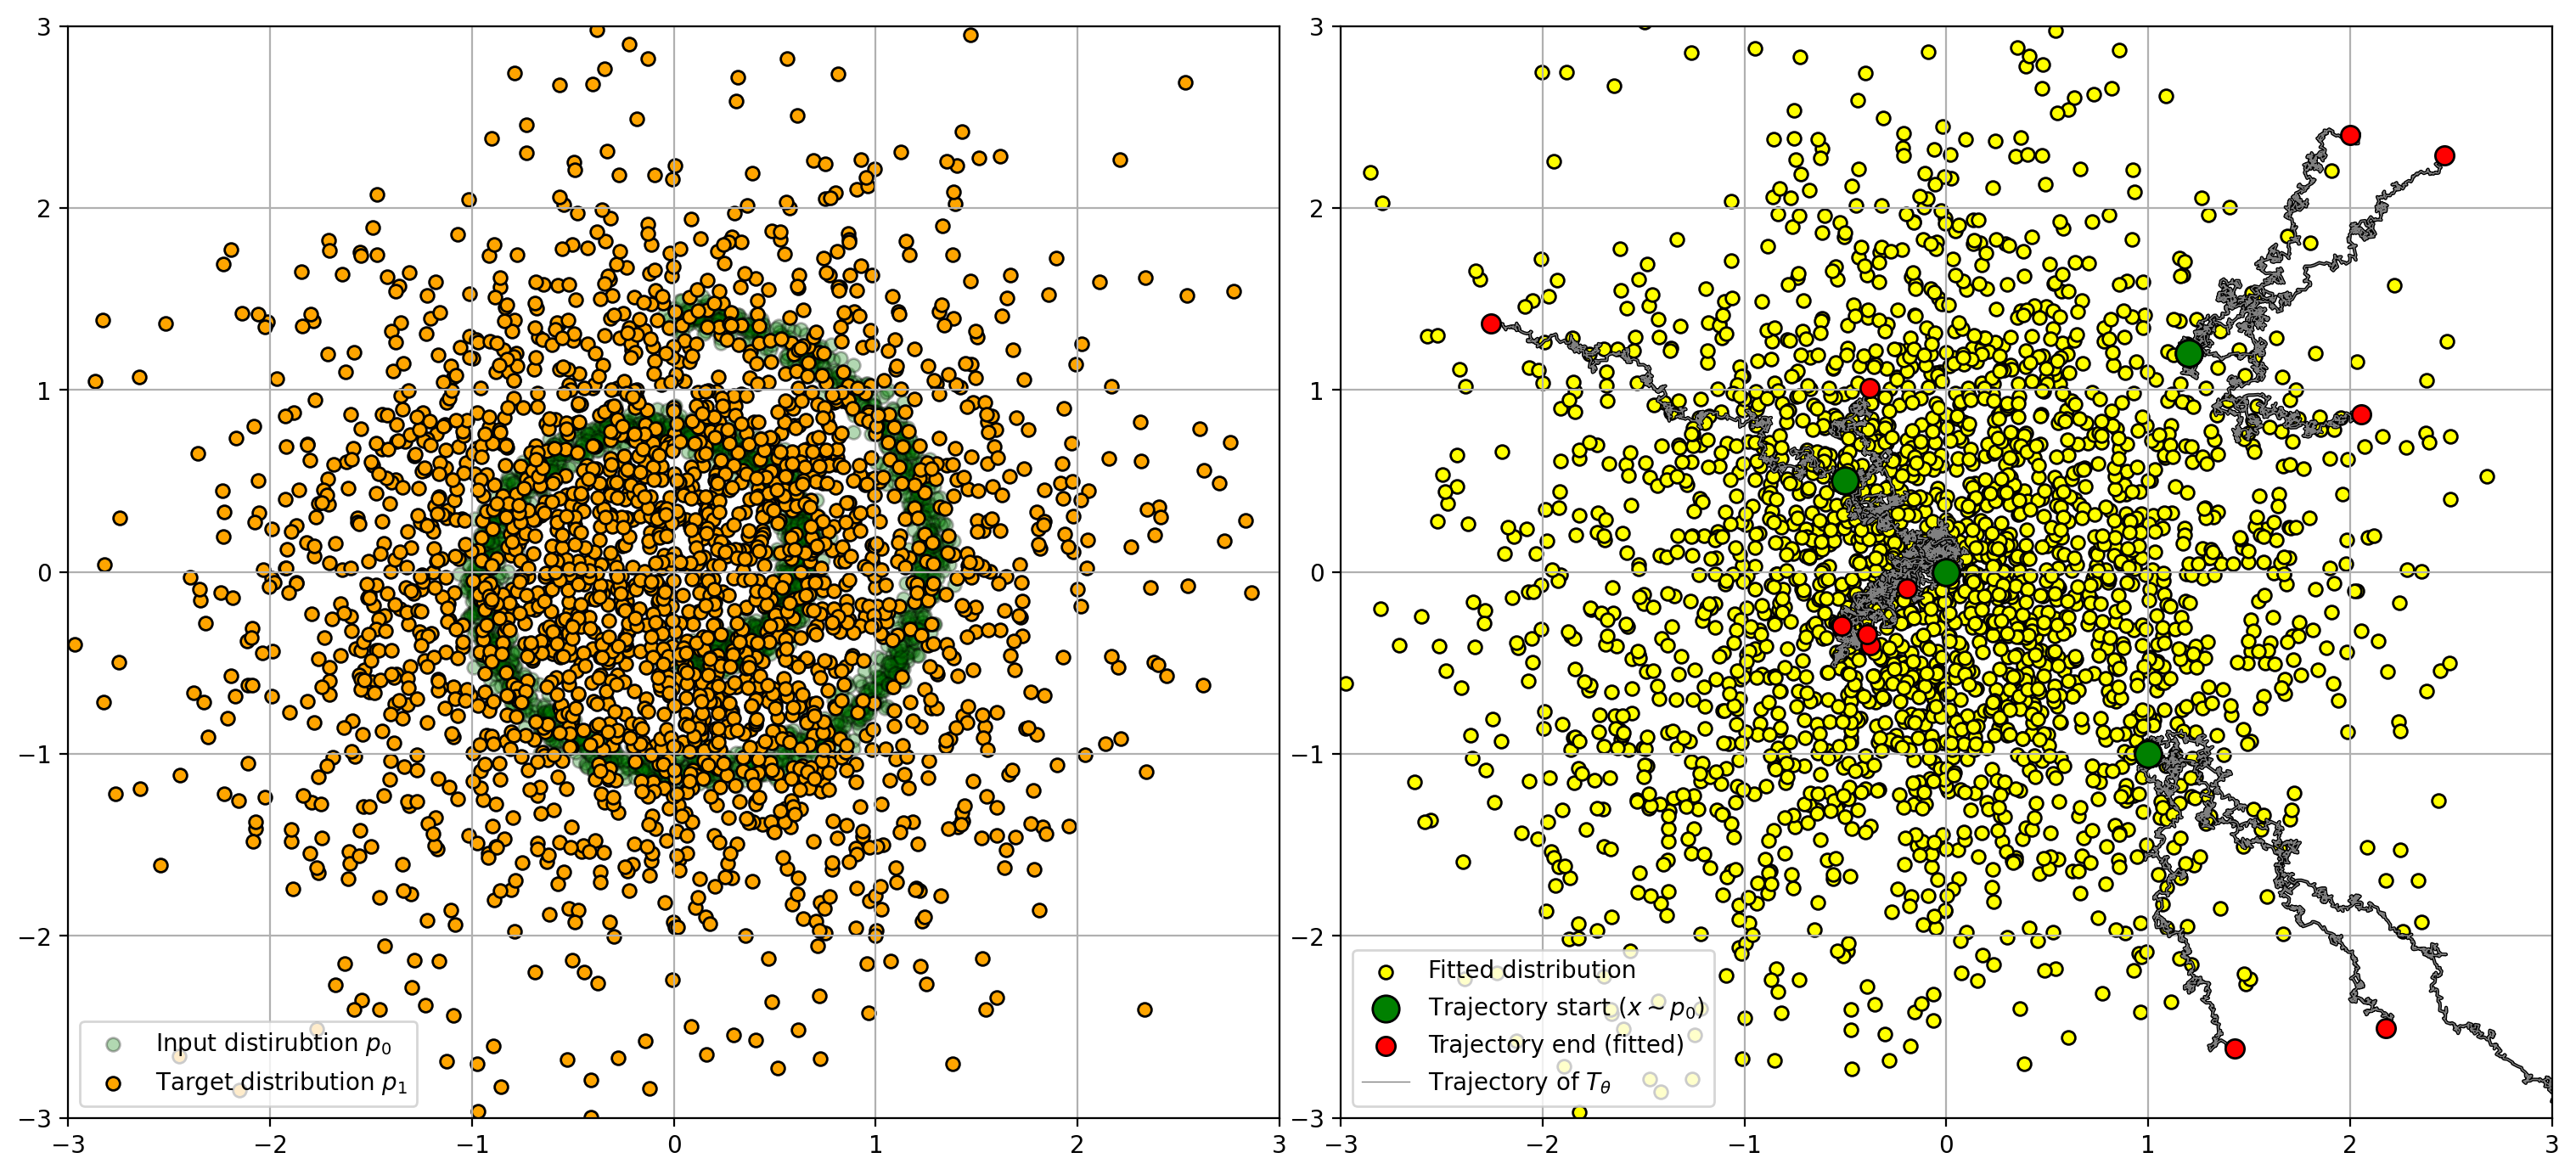

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

y_samples = sample_2d_gaussian(int(DATA_N*0.5))
x_samples = sample_2d_swiss_roll(int(DATA_N*0.5), std=STD)
trajectory, y_pred = solver_b.solve(x_samples)

tr_samples = torch.tensor([[0.0, 0.0], [1, -1], [-0.5, 0.5], [1.2, 1.2]])

tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)

trajectory_example, pred_example = solver_b.solve(tr_samples)

#print(pred_example)

ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.1)


#### $V_{mean}(x,t)$ = $[V_{\theta}(x,t) - V_{\phi}(x,t)] / 2$ - velocity/drift from Gaussian to Swiss Roll

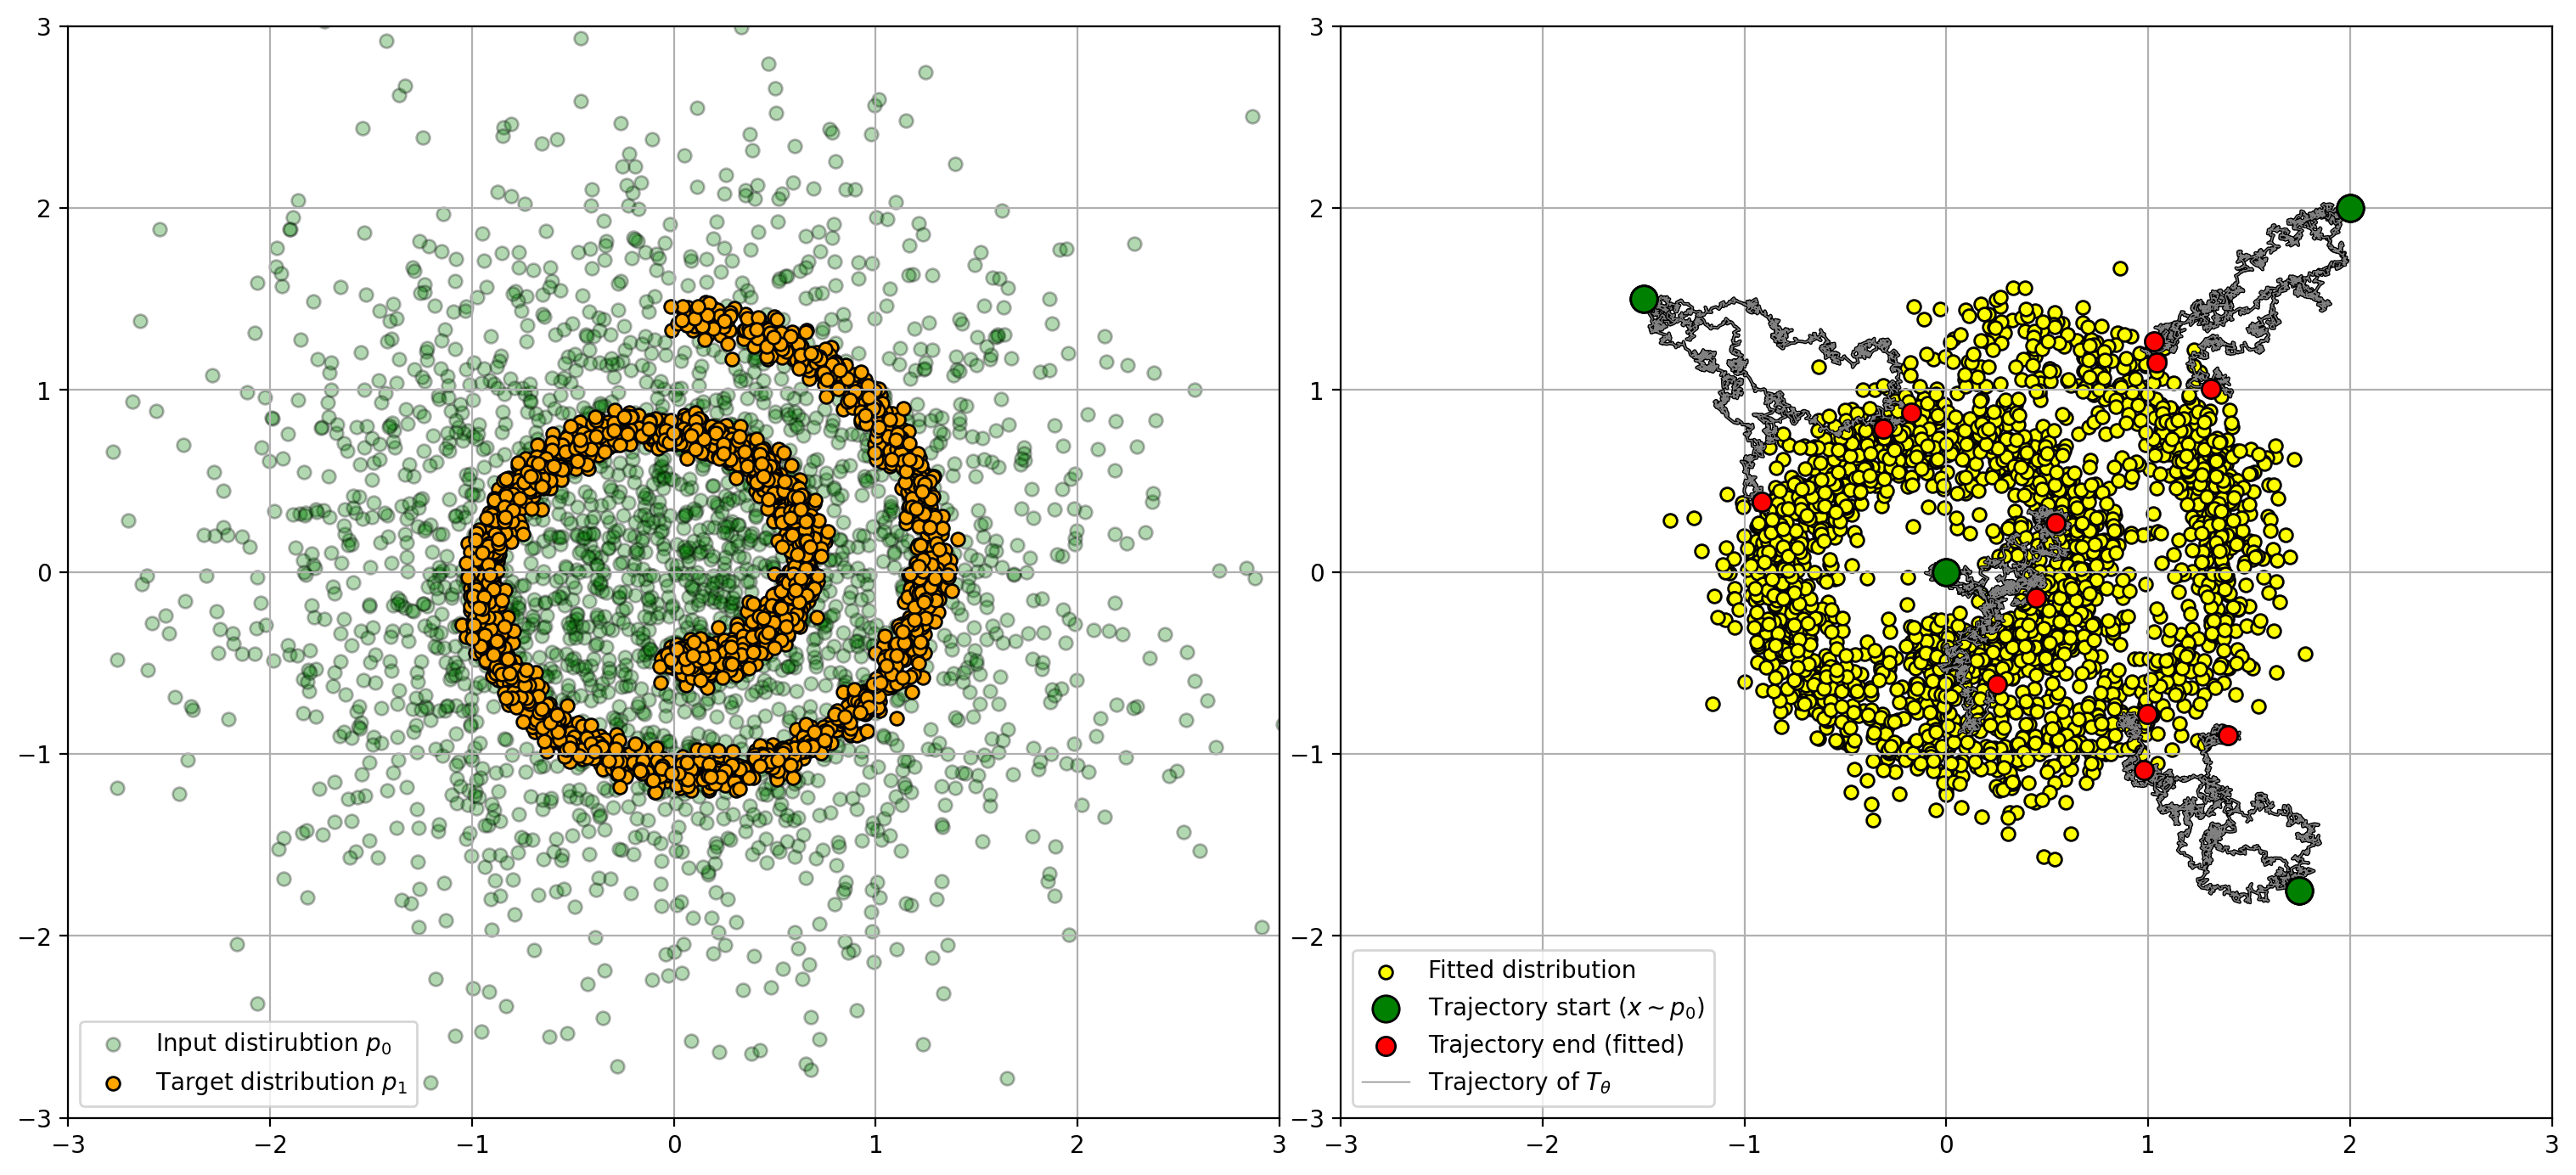

In [12]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6.75), dpi=200)

for ax in axes:
    ax.grid(zorder=-20)

x_samples = sample_2d_gaussian(int(DATA_N*0.5))
y_samples = sample_2d_swiss_roll(int(DATA_N*0.5), std=STD)
trajectory, y_pred = solver.solve_2(x_samples, velocity_backward)

tr_samples = torch.tensor([[0.0, 0.0], [1.75, -1.75], [-1.5, 1.5], [2, 2]])

tr_samples = tr_samples[None].repeat(3, 1, 1).reshape(12, 2)#12 not 4    3 not 1

axes[0].scatter(x_samples[:, 0], x_samples[:, 1], alpha=0.3, 
                c="g", s=32, edgecolors="black", label = r"Input distirubtion $p_0$")
axes[0].scatter(y_samples[:, 0], y_samples[:, 1], 
                c="orange", s=32, edgecolors="black", label = r"Target distribution $p_1$")

ax.scatter(y_pred[:, 0], y_pred[:, 1], 
           c="yellow", s=32, edgecolors="black", label = "Fitted distribution", zorder=1)

trajectory_example, pred_example = solver.solve_2(tr_samples, velocity_backward)

#print(pred_example)

ax.scatter(tr_samples[:, 0], tr_samples[:, 1], 
   c="g", s=128, edgecolors="black", label = r"Trajectory start ($x \sim p_0$)", zorder=3)

ax.scatter(trajectory_example[:, -1, 0], trajectory_example[:, -1, 1], 
   c="red", s=64, edgecolors="black", label = r"Trajectory end (fitted)", zorder=3)

for i in range(12):
    ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "black", markeredgecolor="black",
         linewidth=1.5, zorder=2)
    if i == 0:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2, label=r"Trajectory of $T_{\theta}$")
    else:
        ax.plot(trajectory_example[i, ::1, 0], trajectory_example[i, ::1, 1], "grey", markeredgecolor="black",
                 linewidth=0.5, zorder=2)

for ax in axes:
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.legend(loc="lower left")

fig.tight_layout(pad=0.1)
